In [1]:
#Project Title : Predicting Stock Market using Traditional and Alternative Data

# The Goal of this Project is to identify the drivers of the stock exchange values of different companies, and build 
# a predictor to predict stock prices over a long term.

# I want to build a predictor that takes into account the 
    #1. Hiring, and popularity of companies using Linkedin data provided by Thinknum
    #2. Past values of stocks 
    #3. Public Sentiment of CEOs using tweets scraped from Twitter
    #4. Employee sentiment using reviews scraped from Glassdoor - This can help us in understanding the health of a 
    #   particular company beforehand. - Pending for the Final Capstone Project
    #5. Weather Data provided by NOAA - Pending for the Final Capstone Project
    #6. More Sentiment Analysis of the geopolitical news around the country
    
    #7. Traditional stock market predictors like oil prices, international stock market prices - Pending for the Final Capstone Project

#WorkFlow in This NOTEBOOK : 
# 1. Get the Linkedin data from ThinkNum between 2015 and 2018
# 2. Get the S&P 500 Stocks data from https://www.kaggle.com/camnugent/sandp500
# 3. Scrape Google to get the complete company names for the symbols in the Stocks Data as Linkedin Data has full company names
# 4. Using full company names, find the companies that are common between the above two datasets.
# 4. Scrape Google to get the the CEO's of each of these companies and their Twitter handle.
# 5. Using Twitter API, download all the tweets of the CEOs.
# 5. Perform a sentiment analysis of all the tweets between 2015 and 2018 and create a timeline.
# 6. Analyze the stocks, company growth and sentiments of the CEOs.

# More Thoughts :
# 1. I am also interested in understanding the correlation between different industries and how they drive each 
# other's stock prices.

# 2. This will help us in understanding which companies' stocks depend more on alternative data, for example, a popular
# CEO will have larger influencing in driving the stock prices.
    
# 2. The analysis will span a time period of 3 years, 2015-2018 for companies across different industries 
# 
# 3. While working on this project, I will be looking for more datasets that can help in improving this predictor.

In [2]:
import pandas as pd
import numpy as np
import ipdb
import matplotlib.pyplot as plt
import re
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.palettes import Spectral11, colorblind, Inferno, BuGn, brewer
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource,\
LinearColorMapper,BasicTicker, PrintfTickFormatter, ColorBar, Dropdown, Select, CustomJS,RadioGroup 
from bokeh.io import curdoc
from bokeh.layouts import column, gridplot 
import datetime as dt
from bs4 import BeautifulSoup
from selenium import webdriver 
import time
import os
import requests
from textblob import TextBlob
!pip install pyquery

In [3]:
import bokeh
bokeh.__version__

'1.4.0'

In [4]:
#Loading the ThinkNum Data
df_linkedin=pd.read_csv('temp_datalab_records_linkedin_company.csv')
relevant_columns=['as_of_date','company_name','followers_count','employees_on_platform','industry']
df_lnkd=df_linkedin[relevant_columns]

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
#Loading the Stocks Data from https://www.kaggle.com/camnugent/sandp500
df_stocks=pd.read_csv('all_stocks_5yr.csv')

In [6]:
df_stocks.head(5)

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [7]:
df_stocks.describe()

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


In [8]:
df_lnkd.shape

(2426196, 5)

In [9]:
df_lnkd.head()

,as_of_date,company_name,followers_count,employees_on_platform,industry
0,2015-09-14,Goldman Sachs,552254,38124,Investment Banking
1,2015-09-15,Goldman Sachs,552862,38141,Investment Banking
2,2015-09-16,United Technologies,59157,14982,Aviation & Aerospace
3,2015-09-16,Novo Nordisk,336175,26448,Pharmaceuticals
4,2015-09-16,"Lowe's Companies, Inc.",134255,62574,Retail


In [10]:
df_lnkd.describe()

,followers_count,employees_on_platform
count,2.426196e+06,2.426196e+06
mean,7.167738e+04,7.587255e+03
std,2.638344e+05,2.412444e+04
min,0.000000e+00,0.000000e+00
25%,2.148000e+03,2.180000e+02
50%,9.335000e+03,1.083000e+03
75%,3.864200e+04,4.513000e+03
max,7.833967e+06,5.779520e+05


In [11]:
#Number of unique company names
from wordcloud import WordCloud
df_lnkd.company_name.unique().shape

(5028,)

In [12]:
#Number of unique industry names
industry=df_lnkd.industry.unique().shape
industry

(141,)

In [13]:
df_lnkd['as_of_date']=pd.to_datetime(df_lnkd['as_of_date'])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
min(df_lnkd['as_of_date'])

Timestamp('2015-09-14 00:00:00')

In [15]:
max(df_lnkd['as_of_date'])

Timestamp('2018-07-17 00:00:00')

In [16]:
#Industries with the Largest Followers

grouped=df_lnkd.groupby('industry').sum().reset_index()
grouped.sort_values('followers_count', ascending=False).head(10)

,industry,followers_count,employees_on_platform
62,Information Technology and Services,19775577695,2383349091
65,Internet,15889193478,540464477
40,Financial Services,10208046449,1701931846
93,Oil & Energy,10078940736,609859377
21,Computer Software,9387919641,490204437
101,Pharmaceuticals,7323159940,645660609
119,Retail,6762282982,1424502315
24,Consumer Goods,6496724677,404053850
4,Automotive,4992425224,531717088
7,Banking,4341912352,961924799


In [17]:
#Industries with the Largest Employees on Linkedin
grouped.sort_values('employees_on_platform', ascending=False).head(10)

,industry,followers_count,employees_on_platform
62,Information Technology and Services,19775577695,2383349091
40,Financial Services,10208046449,1701931846
119,Retail,6762282982,1424502315
7,Banking,4341912352,961924799
127,Telecommunications,4243041664,925623563
101,Pharmaceuticals,7323159940,645660609
93,Oil & Energy,10078940736,609859377
65,Internet,15889193478,540464477
4,Automotive,4992425224,531717088
21,Computer Software,9387919641,490204437


In [21]:
#We select certain industries that have large amount of companies and less noisy data by visual inspection of the above plots
#select_ind=['Pharmaceuticals','Retail','Hospital & Health Care','Banking','Information Technology and Services',\
#           'Internet','Semiconductors','Oil & Energy','Automotive','Consumer Goods','Mining & Metals','Chemicals','Financial Services',\
#           'Computer Software','Defense & Space','Airlines/Aviation']

#For the purpose of this exploratory analysis, I will select only one industry
# In my final capstone project, I intend to use all the above industries for my analysis
plt.style.use('ggplot')

select_ind=['Information Technology and Services']

#Plotting only the Largest companies in terms of employees

df_large_ind=pd.DataFrame()

for ind in select_ind:
    sel_ind=df_lnkd[df_lnkd.industry==ind]
    #unq_comp=sel_ind.company_name.unique()
    
    grouped_comp=sel_ind.groupby('company_name').sum()['employees_on_platform'].nlargest(10)
    largest_companies=grouped_comp.keys()
    
    for icomp in largest_companies:
        sel_comp=sel_ind[sel_ind.company_name==icomp]
        sel_comp=sel_comp.sort_values(by='as_of_date')
        #normalize data for each company as we wish to see the growth rather than absolute numbers
        sel_comp['followers_count']=sel_comp['followers_count']-sel_comp['followers_count'].mean()
        sel_comp['employees_on_platform']=sel_comp['employees_on_platform']-sel_comp['employees_on_platform'].mean()
        df_large_ind=df_large_ind.append(sel_comp)

In [22]:
df_large_ind.shape

(8144, 5)

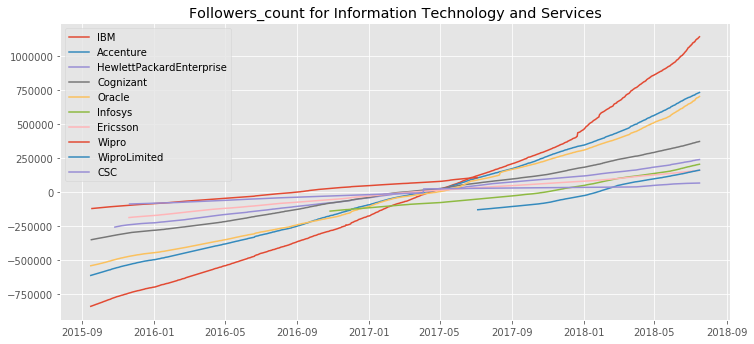

In [23]:
#Plotting the Time series for largest companies

fig=plt.figure(figsize=(12,12))
for i,ind in enumerate(select_ind):
    ax=fig.add_subplot(2,1,i+1)
    sel_ind=df_large_ind[df_large_ind.industry==ind]

    comps=sel_ind['company_name'].unique()
    for icomp in comps:
        sel_comp=sel_ind[sel_ind.company_name==icomp]
        label=re.sub('\W+','', icomp )
        ax.plot(sel_comp['as_of_date'],sel_comp['followers_count'],label=label)
        ax.legend(loc='best')
    ax.set_title('Followers_count for '+ind)
    
#The number of Followers have been steadily increasing on Linkedin. This might tell us more
# about the popularity of Linkedin itself rathern than the company's growth.

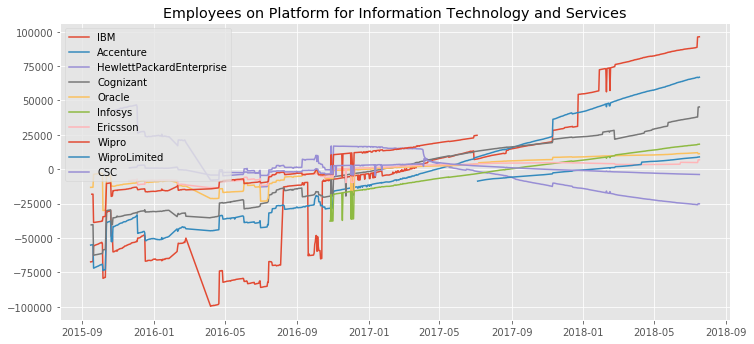

In [24]:
fig=plt.figure(figsize=(12,12))
for i,ind in enumerate(select_ind):
    ax=fig.add_subplot(2,1,i+1)
    sel_ind=df_large_ind[df_large_ind.industry==ind]
    comps=sel_ind['company_name'].unique()

    for icomp in comps:
        sel_comp=sel_ind[sel_ind.company_name==icomp]
        label=re.sub('\W+','', icomp )
        ax.plot(sel_comp['as_of_date'],sel_comp['employees_on_platform'],label=label)
        ax.legend()
    ax.set_title('Employees on Platform for '+ind)
    
#The number of employees however does not show a linear growth. In fact, for some
# of the companies the employees have decreased

In [25]:
df_stocks=pd.read_csv('all_stocks_5yr.csv')

In [26]:
#scrape stock symbols
#Please comment this if don't need to scrape again and simply load the file from the 
# next cell
'''
def scrape_stocks(stock_ticks):
    options = webdriver.ChromeOptions()
    options.add_argument('--ignore-ssl-errors=yes')
    options.add_argument('--ignore-certificate-errors')
    browser = webdriver.Chrome(options=options)
    #browser.implicitly_wait(10)
    stock_dic={}
    for tickr in stock_ticks:
        time.sleep(5)
        search_string = tickr+' stock symbol'
        print(search_string)
        for i in range(1):
            search_str="https://www.google.com/search?q=" + search_string + "&start=" + str(i)
            browser.get(search_str) 
            html_source = browser.page_source
            soup = BeautifulSoup(html_source)
            spans=soup.find_all('span',attrs={'class':'vk_bk'})
            try : 
                span=spans[0]
                stock_dic[tickr]=span.text
            except IndexError:
                pass

    browser.quit()
    df=pd.DataFrame([stock_dic]).T
    df.to_csv('stock_symbols_file.csv')

stock_ticks=df_stocks['Name'].unique()    
scrape_stocks(stock_ticks)
'''

AAL stock symbol
AAPL stock symbol


NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=84.0.4147.105)


In [29]:
df_stocks.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'Name'], dtype='object')

In [35]:
df_stocks['date']=pd.to_datetime(df_stocks['date'])

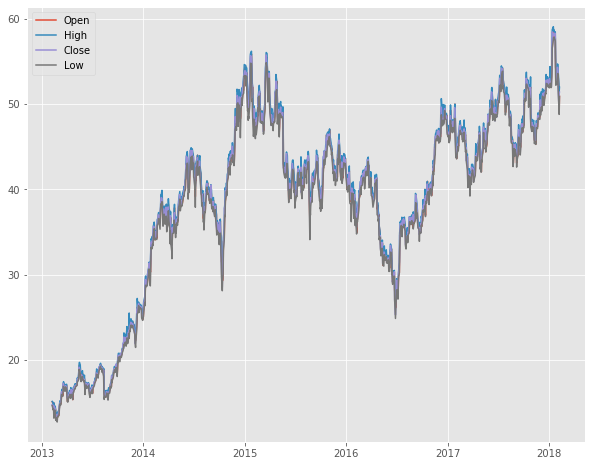

In [41]:
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(111)
unq_sym=df_stocks['Name'].unique()
#Looking at Time series for
for sym in unq_sym[:1]:
    df_sel=df_stocks[df_stocks['Name']==sym]
    df_sel=df_sel.sort_values(by='date')
    ax.plot(df_sel['date'],df_sel['open'],label='Open')
    ax.plot(df_sel['date'],df_sel['high'],label='High')
    ax.plot(df_sel['date'],df_sel['close'],label='Close')
    ax.plot(df_sel['date'],df_sel['low'],label='Low')
    ax.plot(df_sel['date'],df_sel['low'],label='Low')
    ax.legend(loc='best')

In [ ]:
# Finding the Unique stock Names
df_stocks['Name'].unique()
df_stocks_names=pd.read_csv('stock_symbols_file.csv')
comp_stocks_full_names=df_stocks_names[u'0'].values
comp_lnkd_full_names=df_lnkd['company_name'].unique()

In [ ]:
#Linking the full company names with the stock symbols and finding the companies in the S&P index dataset

In [ ]:
def format_comp_name(comp_name):
    comp_name=comp_name.lower()
    comp_name=re.sub('inc','', comp_name)
    comp_name=re.sub('corporation','', comp_name)
    comp_name=re.sub('corp','', comp_name)
    comp_name=re.sub('\W+','', comp_name)
    return comp_name

In [ ]:
df_lnkd['company_name_format']=df_lnkd['company_name'].apply(format_comp_name)
comp_stocks_full_names_format=[format_comp_name(icomp) for icomp in comp_stocks_full_names]

In [ ]:
#Finding common companies between the stocks dataframe and the linkedin dataframe

df_select=pd.DataFrame()
for icomp in comp_stocks_full_names_format:
    row_select=df_lnkd[df_lnkd['company_name_format']==icomp]
    df_select=df_select.append(row_select)

In [ ]:
df_select.shape

In [ ]:
df_select.head()

In [ ]:
common_companies=df_select.company_name.unique()

In [ ]:
df_select.to_csv('df_common.csv')

In [ ]:
#Downloading the names of the CEOs of S&P 500 companies
def download_company_ceo(company_names):
    options = webdriver.ChromeOptions()
    options.add_argument('--ignore-ssl-errors=yes')
    options.add_argument('--ignore-certificate-errors')
    browser = webdriver.Chrome(options=options)
    twitter_ceo={}
    twitter_handle={}
    for scomp in company_names[-6:-4]:
        time.sleep(5)
        search_string = 'CEO of '+ scomp
        print(search_string)
        for i in range(1):
            search_str="https://www.google.com/search?q=" + search_string + "&start=" + str(i)
            browser.get(search_str) 
            html_source = browser.page_source
            soup = BeautifulSoup(html_source)
            spans=soup.find_all('a',attrs={'class':'FLP8od'})
            try :
                span=spans[0]
                ceo_name=span.text
                time.sleep(5)
                search_string = ceo_name+' twitter'
                search_str="https://www.google.com/search?q=" + search_string + "&start=" + str(i)
                browser.get(search_str) 
                html_source = browser.page_source
                soup = BeautifulSoup(html_source)
                ipdb.set_trace()
                #spans=soup.find_all('h3',attrs={'class':'LC20lb DKV0Md'})
                #spans=soup.find_all('a',attrs={'class':'r'})
                spans=soup.find_all('cite',attrs={'class':'ellip D5gSDf bwSSse iUh30'})
                tt=spans[0].text
                twitter_handle=tt[tt.find("(")+1:tt.find(")")]
                twitter_handle=re.sub('@','',twitter_handle)
                twitter_ceo[scomp]=ceo_name
                twitter_handle[scomp]=twitter_handle
            except: 
                pass
    browser.quit()
    df_twitter=pd.DataFrame([twitter_dic]).T
    df_twitter.to_csv('ceo_twitter_handles.csv')

#Get Names of the companies
df_select=pd.read_csv('df_common.csv')
company_names=df_select['company_name'].unique()
download_company_ceo(company_names)

In [ ]:
#Download tweets of the S&P 500 CEOs
#Some of them don't have twitter accounts, so I have manually deleted some of the wrong downloads
# I use the package available at https://github.com/marquisvictor/Optimized-Modified-GetOldTweets3-OMGOT/blob/master/GetOldTweets3-0.0.10/GetOldTweets3.py
df_handles=pd.read_csv('ceo_twitter_handles.csv')
vals=df_handles['0'].values
handles=[]
#valid_handle=[]
for val in vals:
    bb=val.split(',')[1]
    hh=re.sub('\W+','',bb)
    handles.append(hh)
    
for hh in handles:
    if not(os.path.exists(hh)):
        os.makedirs(hh)
    os.chdir(hh)
    ! ../GetOldTweets3.py --username $hh --since 2015-01-01 --until 2019-01-01
    os.chdir('../')

In [ ]:
def clean_tweet(tweet):
    tweet = tweet.lower()
    regs = [
        r'(\/\/www[^\s]+)',
        r'(pic.twitter.com\/[^\s]+)',
        r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)',
        r'(?i)\b((?:https?:\/\/[^\s]+))',
        r'https'
    ]
    prev = tweet
    for reg in regs:
        prev = re.sub(reg, " ", prev)
    return prev

def get_tweets_list(account):
    tweets = []
    path='/Users/garima/'
    with open(f'{path}tweet_folders/{account}/output_got.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        keys = next(csv_reader)
        for row in csv_reader:
            tweet = {}
            tweet[keys[0]] = row[0]
            tweet[keys[1]] = row[1]
            tweet[keys[6]] = clean_tweet(row[6])
            tweets.append(tweet)
    return tweets

def get_tweets(username):
    l = get_tweets_list(username)
    l.reverse()
    return l

def generate_wordcloud(tweets):
    '''Generates a WordCloud from a list of tweets'''
    tweets_con = ''
    for t in tweets:
        tweets_con += t['text']
    return WordCloud(background_color='white', width=1000, height=600).generate(tweets_con)

def plot_wordcloud(wc, title):
    '''Plots a given wordcloud and saves locally in the preferred style'''
    plt.title(title, fontsize=14)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')

In [ ]:
#Loading the tweets of only Donald Trump and Tim Cook for this EDA
for ceo_handle in folders:
    tweets=get_tweets_list(ceo_handle)
    tweets.reverse()
    wc=generate_wordcloud(tweets)
    plot_wordcloud(wc,f'@{ceo_handle}Keywords')

In [ ]:
polarity_dic={}
subj_dic={}
def calc_sentiment(tweets):
    pol = []
    sub = []
    time = []
    for tweet in tweets:
        ss = TextBlob(tweet['text']).sentiment
        date = tweet['date'].split(' ')[0]
        date=dt.datetime.strptime(date,'%Y-%m-%d')
        polarity_dic[date]=ss[0]
        subj_dic[date]=ss[1]
    return (polarity_dic,subj_dic)

In [ ]:
for ceo_handle in folders:
    tweets=get_tweets_list(ceo_handle)
    tweets.reverse()
    polarity_dic,subj_dic=calc_sentiment(tweets)
    df=pd.DataFrame([polarity_dic]).T
    df.to_csv(ceo_handle+'_polarity.csv')
    df=pd.DataFrame([subj_dic]).T
    df.to_csv(ceo_handle+'_subjectivity.csv')

In [ ]:
#Loading the Tweet sentiments for only two people in this notebook

#To understand the influence of political environment on stocks
df_trump=pd.read_csv('realDonaldTrump_polarity.csv')

#To understand the influence of CEO's sentiments on stocks
df_tim=pd.read_csv('tim_cook_polarity.csv')

In [ ]:
output_notebook()
def bkapp(doc):
    TOOLS = 'crosshair,save,pan,box_zoom,reset,wheel_zoom'
    p = figure(title="Employees on Linkedin through Time", y_axis_type="log",x_axis_type='datetime', tools = TOOLS)

    #sample df_comp
    df_comp=df_select[df_select['company_name']=='Apple']
    df_comp=df_comp.sort_values(by='as_of_date')

    source = ColumnDataSource(data={'x': df_comp['as_of_date'], 'y': df_comp['employees_on_platform']})
    source2 = ColumnDataSource(data={'x': df_comp['as_of_date'], 'y': df_comp['followers_count']})

    #p.line(df_comp['as_of_date'], df_comp['employees_on_platform'], legend=icomp, line_color="purple", line_width = 3)
    p.line(x='x',y='y',source=source,line_width=3,line_color="#f46d43",legend='Employees')
    p.line(x='x',y='y',source=source2,line_width=3,line_color="blue",line_alpha=0.3,legend='Followers')
    
    p.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=\
                          [('Date', '@x{%F}'),('Employees', '@y')],\
                         formatters={'@x': 'datetime'}))
    p.plot_width =800

    def callback(attr, old, new):
        df_comp=df_select[df_select['company_name']==new]
        df_comp=df_comp.sort_values(by='as_of_date')
        y_val=df_comp['employees_on_platform']
        y_val2=df_comp['followers_count']
        df_new=pd.DataFrame({'x':df_comp['as_of_date'],'y':y_val})
        df_new2=pd.DataFrame({'x':df_comp['as_of_date'],'y':y_val2})
        source.data=ColumnDataSource.from_df(df_new)
        source2.data=ColumnDataSource.from_df(df_new2)

    menu= Select(options=list(common_companies), value='Apple', title='Distribution')
    menu.on_change('value', callback) 
 
    doc.add_root(column(menu, p))
    doc.theme = Theme(json=yaml.load("""
        attrs:
            Figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 500
                width: 800
            Grid:
                grid_line_dash: [6, 4]
                grid_line_color: white
    """, Loader=yaml.FullLoader))
    
show(bkapp)

In [ ]:
output_notebook()
def bkapp(doc):
    TOOLS = 'crosshair,save,pan,box_zoom,reset,wheel_zoom'
    p = figure(title="Stocks through Time", y_axis_type="linear",x_axis_type='datetime', tools = TOOLS)

    #sample df_comp
    df_comp=df_select[df_select['company_name']=='Apple']
    df_comp=df_comp.sort_values(by='as_of_date')

    source = ColumnDataSource(data={'x': df_comp['as_of_date'], 'y': df_comp['employees_on_platform']})
    source2 = ColumnDataSource(data={'x': df_comp['as_of_date'], 'y': df_comp['followers_count']})

    #p.line(df_comp['as_of_date'], df_comp['employees_on_platform'], legend=icomp, line_color="purple", line_width = 3)
    p.line(x='x',y='y',source=source,line_width=3,line_color="#f46d43",legend='Employees')
    p.line(x='x',y='y',source=source2,line_width=3,line_color="blue",line_alpha=0.3,legend='Followers')
    
    p.add_tools(HoverTool(show_arrow=True, line_policy='next', tooltips=\
                          [('Date', '@as_of_date{%F}'),('Employees', '@employees_on_platform{%F}')],\
                         formatters={'@DateTime': 'datetime'}))
    p.plot_width =800

    def callback(attr, old, new):
        df_comp=df_select[df_select['company_name']==new]
        df_comp=df_comp.sort_values(by='as_of_date')
        y_val=df_comp['employees_on_platform']
        y_val2=df_comp['followers_count']
        df_new=pd.DataFrame({'x':df_comp['as_of_date'],'y':y_val})
        df_new2=pd.DataFrame({'x':df_comp['as_of_date'],'y':y_val2})
        source.data=ColumnDataSource.from_df(df_new)
        source2.data=ColumnDataSource.from_df(df_new2)

    menu= Select(options=list(common_companies), value='Apple', title='Distribution')
    menu.on_change('value', callback) 
 
    doc.add_root(column(menu, p))
    doc.theme = Theme(json=yaml.load("""
        attrs:
            Figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 500
                width: 800
            Grid:
                grid_line_dash: [6, 4]
                grid_line_color: white
    """, Loader=yaml.FullLoader))
    
show(bkapp)

In [ ]:
#Finding the tweets of leaders of these companies and analyzing their sentiments
# glassdoor reviews - long term, weather - short term
#df_sentiments=pd.load_csv()